## Introduction

Task: Classifying 29 different ASL hand patterns using a training data set containing 87,000 images which are 200 x 200 pixels.

This project will mostly utilize the [L4_Transfer_Learning](https://https://colab.research.google.com/drive/1naQBnFQKjcWoWm3ztKMRBglIfpJWanQ_#scrollTo=GIFiPVMpTxYt) Notebook, a part of the CAIS++ curriculum.


In [1]:
# Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data

### Downloading the Data

We download the zipped data from the Kaggle repository and put it in our Google Drive. Then we mount our Google Drive to the Colab Notebook so that we can access the data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# see that the .zip file is saved
!ls
# install linux unzip tool 
!sudo apt-get install unzip
# create /data file in working directory
!mkdir ./data
# unzip the data file and move it to the data folder
!ls
!unzip ./drive/MyDrive/archive.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: ./data/asl_alph

### Creating a Validation Set

In [4]:
!pip install split-folders
import splitfolders

splitfolders.ratio("./data/asl_alphabet_train/asl_alphabet_train", output="./data/pretrain",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 87000 files [00:13, 6307.40 files/s]


### Transformations

In [5]:
# image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/pretrain'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

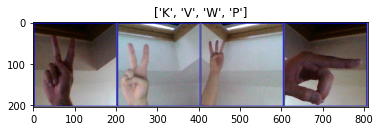

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Baseline Model & Training Parameters

In [9]:
# load the resnet model
model_ft = models.resnet18(pretrained=True)
# find the input size of the FC layers
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
print(model_ft.fc.out_features)

# modify the FC layer to output 29
model_ft.fc = nn.Linear(num_ftrs, 29)

# save model to device
model_ft = model_ft.to(device)

# define loss for categorical classification
criterion = nn.CrossEntropyLoss()

# define whatever optimizer you want!
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# decay your learning rate across epochs-- this helps our model converge better and prevents overshooting a local minima
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

512
1000


# Actually Training

In [10]:
# train the model!
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4809 Acc: 0.8497
val Loss: 0.2180 Acc: 0.9298
Epoch 1/9
----------
train Loss: 0.0776 Acc: 0.9759
val Loss: 0.1178 Acc: 0.9620
Epoch 2/9
----------
train Loss: 0.0466 Acc: 0.9862
val Loss: 0.1477 Acc: 0.9546
Epoch 3/9
----------
train Loss: 0.0303 Acc: 0.9911
val Loss: 0.0560 Acc: 0.9829
Epoch 4/9
----------
train Loss: 0.0204 Acc: 0.9938
val Loss: 0.1214 Acc: 0.9622
Epoch 5/9
----------
train Loss: 0.0175 Acc: 0.9946
val Loss: 0.0309 Acc: 0.9892
Epoch 6/9
----------
train Loss: 0.0138 Acc: 0.9961
val Loss: 0.0594 Acc: 0.9802
Epoch 7/9
----------
train Loss: 0.0008 Acc: 0.9998
val Loss: 0.0283 Acc: 0.9906
Epoch 8/9
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0181 Acc: 0.9931
Epoch 9/9
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0238 Acc: 0.9920
Training complete in 79m 8s
Best val Acc: 0.993103


# Testing

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

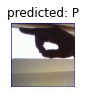

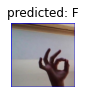

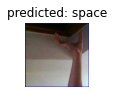

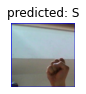

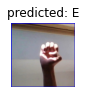

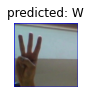

In [ ]:
visualize_model(model_ft)

In [12]:
#accuracy function from https://stackoverflow.com/questions/52176178/pytorch-model-accuracy-test
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model_ft(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    

In [14]:
check_accuracy(dataloaders['test'], model_ft)

Got 8636 / 8700 with accuracy 99.26
